# Bidirectional LSTM time series classification 
- Predict Google stock prices given last 10 years of data (2010 - 2020)

- This notebook is inspired by the following tutorials:
    - https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/03.stock_prediction.ipynb
    - https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    - https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233


# A. Setup

### A.1 Get more ram on google colab

In [1]:
more_ram = True
parameter_search = False
search_best_model = False

In [2]:
# 1. Set run time to GPU
# code to crash colab and get more ram
if not more_ram:
    a = []
    while(1):
        a.append(1)

### A.2 Load libraries and variables


In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
label_col = "Close"
date_col = "Date"
scale_type = "minmax"
features_list = [label_col]
seq_len = 100

# activate GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### A.3 Fix randomness for reproducible results

In [5]:
# Fix random number for reproducible results
seed_value= 0

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

tf.random.set_seed(seed_value)

### A.4 Load dataset

https://finance.yahoo.com/quote/GOOG/history?period1=1568325161&period2=1599947561&interval=1d&filter=history&frequency=1d

- This dataset is obtained from yahoo finance stock price history

In [6]:
import os
data_path = '/content/drive/My Drive/data'
df = pd.read_csv(os.path.join(data_path, 'google_stocks.csv'), parse_dates=[date_col]).sort_values(date_col)

print("Dataframe: ", df.shape)
df.head()

Dataframe:  (2518, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-09-13,239.552094,241.270660,238.869659,240.234543,240.234543,4499700
1,2010-09-14,240.105026,241.469910,239.143631,239.317978,239.317978,4449500
2,2010-09-15,239.078873,240.045258,238.356583,239.422592,239.422592,4823600
3,2010-09-16,239.078873,240.324203,238.809875,239.631805,239.631805,3953700
4,2010-09-17,240.971771,244.682861,239.691574,244.159836,244.159836,11325400


### A.4 Data exploration

In [7]:
def plot_timeseries_label(df: pd.DataFrame, date_col: str, label_col: str, y_label_name = "Close Price (USD)"):
    """
    Plot time series label of interest (Eg. change in close prices of stock over time)

    Inputs:
    - df: dataframe of data
    - date_col: col name of date
    - label_col: col name of label
    - y_label_name: name of label axis, defaults to "Close Price (USD)"
    """
    ax = df.plot(x=date_col, y=label_col);
    ax.set_xlabel(date_col)
    ax.set_ylabel(y_label_name)

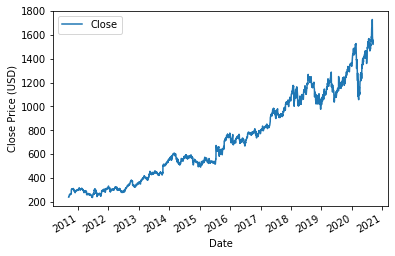

In [8]:
plot_timeseries_label(df, date_col, label_col)

### A.5 Data splits

- Train data: ~first 7 years
- Test data: ~last 3 years

In [9]:
# Fix test index to be the latter ~16% of stock data
test_idx = len(df) - int(len(df) / 6)

train_df = df[[date_col] + features_list].iloc[:test_idx]
test_df = df[[date_col] + features_list].iloc[test_idx:]

print("X train= " , train_df.shape)
print("X test= " , test_df.shape)

X train=  (2099, 2)
X test=  (419, 2)


## B. Data Processing

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

Things to consider:
- Data imputation / missing values
- Handling outliers
    - detect and remove
    - detect and capp 
- Log transform:
    - helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
    - In most of the cases the magnitude order of the data changes within the range of the data. For instance, the difference between ages 15 and 20 is not equal to the ages 65 and 70. In terms of years, yes, they are identical, but for all other aspects, 5 years of difference in young ages mean a higher magnitude difference. This type of data comes from a multiplicative process and log transform normalizes the magnitude differences like that.
    - It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.
    - NOTE: The data you apply log transform must have only positive values, otherwise you receive an error. Also, you can add 1 to your data before transform it. Thus, you ensure the output of the transformation to be positive.
- One-hot-encoding:
    - This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information.
- Scaling:
    - makes sure different scales don't affect model

### B.2 Feature scaling 


https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Scaling features:
- purpose: Having features on a similar scale can help the gradient descent converge more quickly towards the minima.
- distance based algorithms: we scale our data before employing a distance based algorithm so that all the features contribute equally to the result. 

Types of scalers:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- StandardScaler: removes the mean and scales the data to unit variance
    - outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values
    - cannot guarantee balanced feature scales in the presence of outliers
- minmax scaler: normalizing to [0,1], sensitive to outliers
- maxabs scaler: absolute values scaled to [0,1], sensitive to outliers
- robust scaler: the centering and scaling statistics based on percentiles
    - not influenced by a few number of very large marginal outliers. 
    - resulting range of the transformed feature values is larger and are approximately similar. 
    - Outliers themselves are still present in the transformed data
- power transformer: applies a power transformation to each feature to make the data more Gaussian-like. 
    - Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms
    -  finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation

- QuantileTransformer: 
    - has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values
    - also can apply a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers
    - robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

- normalizer:
    - rescales the vector for each sample to have unit norm, independently of the distribution of the samples


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

def fit_scaler(train_df, features_list: list, scale_type: str):
    """
    Fit scaler on train data
    inputs:
    - train_df: dataframe of x train data
    - features_list: list of features to be scaled
    - scale_type: type of scale to use (ie. standardize, normalize)

    scalers takes input (num_samples, num_features) and scales all features
    """
    scaler_dict = {
        "standard" : StandardScaler(), 
        "minmax" : MinMaxScaler(feature_range=(0, 1)) , 
        "maxabs" : MaxAbsScaler(), 
        "robust": RobustScaler(quantile_range=(25, 75)),
        "power_yeo_johnson": PowerTransformer(method='yeo-johnson'),
        "power_box_cox" : PowerTransformer(method='box-cox'),
        "quartile_normal":  QuantileTransformer(output_distribution='normal'),
        "quartile_uniform": QuantileTransformer(output_distribution='uniform'),
        "normalizer": Normalizer()
    }
    
    scaler = scaler_dict[scale_type].fit(train_df[features_list])

    return scaler

In [11]:
# Fit the standardized scaler on the TRAIN data
scaler = fit_scaler(train_df, features_list, scale_type)

# Tranform both TRAIN and TEST data on the scaler fitted on TRAIN data
train_df[features_list] = scaler.transform(train_df[features_list])
test_df[features_list] = scaler.transform(test_df[features_list])

test_df.head()

,Date,Close
2099,2019-01-15,0.814708
2100,2019-01-16,0.818410
2101,2019-01-17,0.827065
2102,2019-01-18,0.835168
2103,2019-01-22,0.808282


### B.3 Check for NaN values

In [12]:
def check_nan(df: pd.DataFrame, features_list: list):
    """
    Check for which features have nan values
    """
    features = []
    for feature in features_list:
        vals = df[feature].values
        if np.isnan(np.sum(vals)):
            features.append(feature)
    
    return features

In [13]:
# Check to see if there are any nan values in any features
    # nan values will be ignored/masked by lstm model
print("train: %d" %len(check_nan(train_df, features_list)))
print("test: %d" % len(check_nan(test_df, features_list)))

train: 0
test: 0


## C. Bidirectional LSTM model

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

- Bidirectional LSTM: 
    - involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - Where LSTM learns linearly, Bidirectional LSTM learns from both past and future to predict current


    


### C.1 Prepare data format for LSTM model
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

Input dimensions:
- Samples. One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps. One time step is one point of observation in the sample.
- Features. One feature is one observation at a time step.

- model by default expects 1 or more samples
- input_shape = (num_time_steps, num_features)

x_train data shape: data.reshape(num_samples, num_time_steps, num_features)

num_time_steps = 70
num_features = 9

In [14]:
def get_valid_feature_values(df: pd.DataFrame, features_list:list, date_col : str):
    """
    Remove convert all invalid values (infinity, None, 'None') to np.nan (so that it can be masked)
    Return feature values as np.array given features of interset (features_list)

    Input:
    - df: dataframe of feature data per uid
    - features_list: list of features to keep 
    """
    # convert +- inf to np.nan
    df = df.replace([np.inf, -np.inf], np.nan)

    # convert "None" to np.nan
    df = df.replace(to_replace="None", value=np.nan)

    # convert None with np.nan
    df.fillna(value=np.nan, inplace=True)

    df = df.sort_values(by=[date_col])

    return df[features_list].values

In [15]:
def prepare_data(df: pd.DataFrame, features_list: list, date_col: str, seq_len: int):
    """
    Preparing data for CNN

    Inputs:
    df: dataframe of data (train or test)
    uids: uids that correspond to the labels, in correct order
    y: corresponding labels
    features_list: list of features to keep
    seq_len: number of sequences / number of time_steps, default to 100

    Outputs:
    X data: (num_samples, num_time_steps, num_features)
    y data: (num_samples, )
    """
    
    data = get_valid_feature_values(df, features_list, date_col)
    X_data = []
    y_data = []

    # Rolling window sequence, moves up by 1 data point every time
    for i in range(seq_len, len(data)):
        # Get sequence of length seq_len up till current i - 1
        X_data.append(data[i - seq_len : i])

        # Get stock price at i (label to predict)
        y_data.append(data[i])


    X_data, y_data = np.array(X_data), np.array(y_data)
    X_data = X_data.reshape(len(X_data), seq_len, len(features_list))

    y_data = y_data.reshape(len(y_data))
    return X_data, y_data 

In [16]:
X_train, y_train = prepare_data(train_df, features_list, date_col, seq_len)
X_test, y_test = prepare_data(test_df, features_list, date_col, seq_len)

num_train = X_train.shape[0]
num_test = X_test.shape[0]

print("X train= ", X_train.shape)
print("X test= " , X_test.shape)

print("y_train= ", y_train.shape)
print("y_test= " , y_test.shape)

X train=  (1999, 100, 1)
X test=  (319, 100, 1)
y_train=  (1999,)
y_test=  (319,)


### C.2 Hyperparameter tuning for LSTM model

https://medium.com/@crawftv/parameter-hyperparameter-tuning-with-bayesian-optimization-7acf42d348e1

Bayesian optimization:
- good approach to hyperparameter tuning for neural net models 
https://github.com/crawftv/Skopt-hyperparameter-tutorial/blob/master/scikit_optimize_tutorial.ipynb

Parameters to tune:

- num_neurons:
    - 1 hidden layer works for simple problems
    - 2 hidden layer reasonably works for complex problems
    - more layers might be better but takes longer to train
- optimizer:
    - https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
    - https://keras.io/api/optimizers/
    - SGD: stochastic gradient descent
        - incremental gradient descent, tries to find min/max error via iteration
        - when objective function is not convex / pseudo conves, it always converges to local min
    - RMSprop:
        - maintain moving average of square of gradients
        - divide gradient by root of average
        - resolve Adagra's diminishing learning rate problem
        - need to specify gamma and learning rate
    - Adam:
        - calculate learning rate for each parameter
        - has good results
    - Adadelta:
        - stochastic gradient descent method, based on adaptive learnign rate per dimension
        - addresses continual decay of learning rates throughout training
        - addresses need for manually selected global learning rate
        - more robust extension of Adagrad
            - adapts learning rates based on moving window of gradient updates
    - Adagrad:
        - parameter-specific learning rates, adaptive to how frequently la parameter gers updated during training 
    - Adamax:
        - variant of Adam based on infinity norm
        - sometimes superior to adam, specially in models with embeddings 
    - Nadam:
        - Adam with Nesterov momentum (slows down when steps are moving further from min)
    - Ftrl: follow the regularized leader
        - L2 and shrinkage-type L2 loss function

- batch_size:
    - limits number of samples to be shown to the network before a weight update can be performed
    - need to tune in some cases because:
        - you could get goot results with large batch size, but are required to make predictions for one observation
    
- learning_rate:
    - hyperparameter for the optimizer
    - determines step size at each iteration while moving towards min of loss function 

- activation functions:
    - https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
    - https://www.google.com/search?q=types+of+activation+functions&rlz=1C5CHFA_enCA786CA786&oq=types+of+activation+functions&aqs=chrome..69i57j0l7.2943j0j9&sourceid=chrome&ie=UTF-8
    - binary step function:
        - threshold based, activates when input to function is over a certain threshold. else, it's deactivated
        - problem: gradient of function becomes zero
    - linear function:
        - gradient of function is not zero, but constant
            - weights and biases will be updated during back-prop, but updating factor will be the same 
    - tanh: [-1, 1]
        - overcome vanishing gradient problem (second derivative sustains for a long range before going to 0)
        - good for non-linearities
        - symmetric around origin = 
        - values range from -1 to 1 = inputs to the next layers will not always be of the same sign
        - usually tanh is preferred from sigmoid, because it's zero-centered and gradients are not restricted to move in a certain direction

    - sigmoid: [0,1]
        - output 0 or 1 (ie. can be used to forget or remember the information)
        - widely used non-linear activation function
        - when gradient approaches 0, network stops learning and it's also not symmetric around 0, so output of the neurons will be of the same sign
        - generally work well for classification, but might be avoided due to vanishing gradient problem 
    
    - relu: [0, upperbound]
        - non-linear activation function, threshold at 0 (ie. all negative values get converted to 0)
        - (+) = doesnt not activate all the neurons at the same time
        - (-) neurons will only be deactivated if the output of the linear transformation is less than 0
        - used very often for hidden layers (should only be used for hidden layers)
        - good place to start

    - leaky relu:
        - improved version of relu
        - doesn't deactivate neurons if gradient is 0
        - if we encounter a dead neurons = leaky relu is best 
    
    - softmax:
        - combination of multiple sigmoids = returns probability for a datapoint belonging to each individual class
        - can be used for multiclass classification problems
        
    



In [17]:
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Masking, Dropout, Bidirectional, LSTM, Dense, Activation
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K

def create_model(num_time_steps: int, num_features: int, dropout_rate=0.2, lstm_layers =[50, 50], lr=0.01, l1=0.01, l2=0.01):
    """
    Create and return Bidirectional LSTM model given parameters

    Inputs:
    - num_time_steps: number of time steps / sequence lengths
    - num_features: number of features in data
    - dropout_rate: default to 0.2
    - lstm_layers: number of hidden neurons and LSTM layers
    - lr (learning rate): default to 0.01
    - l1 (l1 penalty): default to 0.01
    - l2 (l2 penalty): default to 0.01

    Output:
    model: Keras model
    """

    opt = Adam(learning_rate = lr)

    #start the model making process and create our first layer
    model = Sequential()

     # Add LSTM layers
        # note: LSTM with no activation = CuDNNLSTM (faster)
    for i, num_neurons in enumerate(lstm_layers):
        if i == 0:
            # LSTM layer 
            model.add(Bidirectional(LSTM(units= num_neurons, return_sequences=True), input_shape=(num_time_steps, num_features)))
            model.add(Dropout(rate=dropout_rate))

        # if last layer
        elif i == len(lstm_layers) - 1:
            # LSTM layer 
            model.add(Bidirectional(LSTM(units= num_neurons, return_sequences=False)))

        else:
            model.add(Bidirectional(LSTM(units= num_neurons, return_sequences=True)))
            model.add(Dropout(rate=dropout_rate))

    # Add prediction layer
        # classes are 0 or 1 = 1, sigmoid
    model.add(Dense(units = 1))

    # binary classification
    model.compile(optimizer=opt, loss='mean_squared_error')

    return model

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor     # wrapper to use keras model with sk-learn 
from keras.callbacks import EarlyStopping

def report_best_params(X_train: np.array, y_train: np.array, search_params: dict, n_splits: int):
    """
    Report best hyperparams for model
    Inputs:
    X_train: np array of train data
    y_train: np array of train data labels
    search_params: range of parameters to test
    n_splits: number of splits for cv validation
    """

    # Regression / continuous prediction
    model = KerasRegressor(build_fn = create_model, epochs=6, batch_size=32, verbose=1)

    search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=search_params, 
        n_jobs = -1,
        n_iter = 10,
        cv= 3)

    search.fit(X_train, y_train)

    # Results from Random Search
    print("\n========================================================")
    print(" Results from Random Search " )
    print("========================================================")
    print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
    print("\n The best score across ALL searched params:\n",
          randm.best_score_)
    print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
    print("\n ========================================================")

In [19]:
"""
1) 
search_params = [
    {
    'num_time_steps': [num_time_steps],
    'num_features': [num_features],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4], 
    'lstm_layers': [(100, 100), (200, 200), (100, 100, 100), (200, 200, 200)],
    'dense_layers': [(100, 100), (200, 200), (100, 100, 100), (200, 200, 200)],
    'lr': [0.001, 0.01, 0.1],
    'l1': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'l2': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'act': ['relu', 'sigmoid', 'tanh']
    }]

"""

if parameter_search:
    # Define mode with parameters num_time_steps and num_features
    num_time_steps = seq_len
    num_features = len(features_list)

    search_params = [
        {
        'num_time_steps': [num_time_steps],
        'num_features': [num_features],
        'dropout_rate': [0.1, 0.2, 0.3, 0.4], 
        'lstm_layers': [[50,50], [100,100], [50,50,50], [100,100,100]],
        'lr': [0.001, 0.01, 0.1],
        'l1': [0.001, 0.01, 0.1],
        'l2': [0.001, 0.01, 0.1]
        }]

    report_best_params(X_train, y_train, search_params, 5)

### C.3 Making and evaluating predictions

Visualize stock price predictions on test set

In [20]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def save_best_model(X_train:np.array, y_train: np.array, X_val:np.array, y_val:np.array, path:str, num_features:int, num_time_steps:int, dropout_rate:np.double, lstm_layers:int, lr:np.double, l1:np.double, l2:np.double):
    """
    Save best model with early stopping
    - best model is one that gives the lowest loss value in validation set

    Inputs: 
    - X_train: train data
    - y_train: labels in train
    - X_val: validation data
    - y_val: labels in validation
    - path: path to save model
    - num_features: number of features in data
    - num_time_steps: number of time_steps / seq length
    - dropout_rate: hyperparameter for model
    - lstm_layers: hyperparameter for model
    - lr: hyperparameter for model
    - l1: hyperparameter for model
    - l2:hyperparameter for model
    """
    
    model = create_model(num_features= num_features, num_time_steps= num_time_steps, dropout_rate=dropout_rate, lstm_layers =lstm_layers, lr=lr, l1=l1, l2=l2)

    # early stopping:
        # when loss on test dataset gets larger, stop training
        # patience = wait N number of epochs to stop training, to overcome random flat spots
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    mc = ModelCheckpoint(path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    # Fit first model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 1000, callbacks=[es, mc])
  
    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [21]:
import matplotlib.pyplot as plt

def plot_predictions(y_pred: np.array, y_test: np.array, scaler, title= 'Google Stock prices prediction'):
    """
    Plot predictions obtained from model against true values

    Inputs:
    - model: fitted model to evaluate
    - X_test: test data
    - y_test: label from test dataset
    - scaler: scaler fitted on test data
    - title: title of graph, default to 'Google Stock prices prediction'

    """
    y_test_inverse = scaler.inverse_transform(y_test.reshape(len(y_test), 1))
    y_pred_inverse = scaler.inverse_transform(y_pred.reshape(len(y_test), 1))
    
    plt.plot(y_test_inverse.reshape(len(y_test_inverse)), label="Actual Price", color='green')
    plt.plot(y_pred_inverse.reshape(len(y_pred_inverse)), label="Predicted Price", color='red')
    
    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Price')
    plt.legend(loc='best')
    
    plt.show();

In [33]:
import statistics

# Find mean forcast error
def calculate_mean_abs_forecast_error(y_pred: np.array, y_test: np.array):
    """
    Calculate the mean absolute forecast error

    Inputs:
    - y_pred: array of y predictions
    - y_test: array of true y labels

    Outputs:
    - mean of mae: average absolute error
    """
    
    mae = np.asarray([abs(y_pred[i] - y_test[i]) for i in range(len(y_pred))])
    print(mae.shape)
    return np.mean(mae)
    

In [25]:
# 1. Save best model
from sklearn.model_selection import train_test_split

num_time_steps = seq_len
num_features = len(X_train[0,0,:])

# Hyperparameters
dropout_rate = 0.2                   # to tune: 0.2 is a good place to start
lstm_layers =[50, 50]
lr=0.0001
l1=0.01
l2=0.01

if search_best_model:
    path= data_path + "best_model.h5"
    # train_test_split = stratifies by label by default
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=88)
    save_best_model(X_train, y_train, X_val, y_val, path, num_features, num_time_steps, dropout_rate, lstm_layers, lr, l1, l2)

# 2. Alternatively, just define a model and evaluate
else:
    model = create_model(num_time_steps= seq_len, num_features= num_features, dropout_rate=0.2, lstm_layers = [50, 50], lr=0.01, l1=0.01, l2=0.01)
    model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
63/63 [==============================] - 1s 19ms/step - loss: 0.0193
Epoch 2/100
63/63 [==============================] - 1s 18ms/step - loss: 8.9553e-04
Epoch 3/100
63/63 [==============================] - 1s 18ms/step - loss: 8.1867e-04
Epoch 4/100
63/63 [==============================] - 1s 18ms/step - loss: 6.3885e-04
Epoch 5/100
63/63 [==============================] - 1s 18ms/step - loss: 7.1761e-04
Epoch 6/100
63/63 [==============================] - 1s 18ms/step - loss: 5.2905e-04
Epoch 7/100
63/63 [==============================] - 1s 18ms/step - loss: 5.1502e-04
Epoch 8/100
63/63 [==============================] - 1s 18ms/step - loss: 3.9250e-04
Epoch 9/100
63/63 [==============================] - 1s 18ms/step - loss: 5.7731e-04
Epoch 10/100
63/63 [==============================] - 1s 18ms/step - loss: 4.6608e-04
Epoch 11/100
63/63 [==============================] - 1s 18ms/step - loss: 4.0808e-04
Epoch 12/100
63/63 [==============================] - 1s 18ms/step 

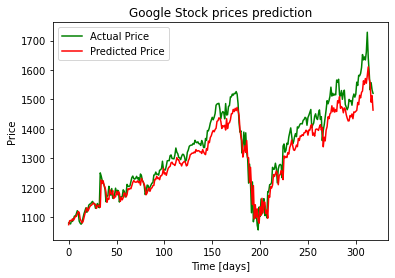

In [26]:
# Make prediction using custom model
y_pred = model.predict(X_test)
plot_predictions(y_pred, y_test, scaler= scaler)

In [34]:
mae = calculate_mean_abs_forecast_error(y_pred, y_test)
print("Mean absolute error: ", mae)

(319, 1)
Mean absolute error:  0.033745214
